In [1]:
import gc
import lightgbm as lgb
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import random
import sys
import time
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
from pandarallel import pandarallel
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [11]:
from utils.constants import *
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, 
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number, plot_sampled_time_series, plot_heatmap
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS
)
from utils.preprocess_helpers import clip_col, split_public_private
from utils.feature_engineering_helpers import feature_gen_pipeline

In [12]:
%load_ext autoreload
%autoreload

In [13]:
def test_strategy(df_subset, seeds=[1020, 923, 5197, 6846]):
    params = {
        'objective': 'binary',
        'device_type': 'cpu',
        'metric': 'binary_logloss',
        'boosting': 'dart',
        'seed': 1020,
        'num_leaves': 60,
        'learning_rate': 0.025,
        'feature_fraction': 0.25,
        'bagging_freq': 3,
        'bagging_fraction': 0.55,
        'n_jobs': -1,
        'lambda_l2': 15,
        'min_data_in_leaf': 75,
        'scale_pos_weight': 1.4
    }
    cat_features = set(CATEGORY_COLUMNS).intersection(df_subset.columns)
    df_subset.loc[:, cat_features] = df_subset.loc[:, cat_features].astype("category")
    df_subset_agg = feature_gen_pipeline(df_subset)
    for seed in seeds:
        X_train, X_val, y_train, y_val = train_test_split(df_subset_agg, labels["target"], test_size=0.2, random_state=seed)
        cat_features = X_train.select_dtypes("category").columns.tolist()
        lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=cat_features)
        lgb_valid = lgb.Dataset(X_val, y_val, categorical_feature=cat_features)
        model = lgb.train(
            params = params,
            train_set = lgb_train,
            num_boost_round = 1000,
            valid_sets = [lgb_train, lgb_valid],
            early_stopping_rounds = 300,
            verbose_eval = 300,
            feval = lgb_amex_metric
        )
        y_val_pred = model.predict(X_val, raw_score=True)
        val_score, val_g, val_t4 = amex_metric(y_val.values, y_val_pred)
        print(seed, val_score)

In [ ]:
def calculate_psi(expected, actual, buckettype='bins', buckets=100, axis=0):
    '''Calculate the PSI (population stability index) across all variables
    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values, same size as expected
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal
    Returns:
       psi_values: ndarray of psi values for each variable
    Author:
       Matthew Burke
       github.com/mwburke
       worksofchart.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable
        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into
        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input


        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])



        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

### Setup

In [14]:
# %%time
# integer_train = read_file(f"{INTERIM_DATA_PATH}/v0/train_integer_master.parquet")

In [15]:
%%time
labels = pd.read_csv(f"{RAW_DATA_PATH}/train_labels.csv")
# if "target" not in integer_train.columns:
#     integer_train = integer_train.merge(labels, on="customer_ID", how="left")

CPU times: user 428 ms, sys: 28.5 ms, total: 457 ms
Wall time: 456 ms


In [19]:
%%time
train = read_file(f"{INTERIM_DATA_PATH}/v3/train_parquet/train_all_variables.parquet")
test1 = read_file(f"{INTERIM_DATA_PATH}/v3/test_parquet/test_all_variables1.parquet")
test2 = read_file(f"{INTERIM_DATA_PATH}/v3/test_parquet/test_all_variables2.parquet")

Shape of data: (5531451, 199)
Shape of data: (5681079, 198)
Shape of data: (5682683, 198)
CPU times: user 1min 4s, sys: 45.9 s, total: 1min 50s
Wall time: 12.7 s


In [20]:
%%time
public_test, private_test = split_public_private(pd.concat([test1, test2], ignore_index=True))

Public size: 5719469, Private size: 5644293
CPU times: user 18.1 s, sys: 12.2 s, total: 30.3 s
Wall time: 30.3 s


In [22]:
del test1, test2

In [23]:
df_list = [train, public_test, private_test]

In [24]:
for df in df_list:
    insert_row_number(df)

Done insertion
Done insertion
Done insertion


In [25]:
strong_columns = ["P_2", "P_3", "B_1", "B_3", "B_4", "D_39", "D_42", "D_43", "D_46", "D_48", "S_3", "S_7"]

In [26]:
# train_corr_df = train.corr()

In [27]:
# train_corr_df.to_csv(f"{INTERIM_DATA_PATH}/v3/train_corr_df.csv", index=False)

### Check Drift

#### Using Kolmogorov Smirnov 2-sample test

In [41]:
from scipy import stats

In [42]:
base_features = train.columns[5:]

In [91]:
max_p_values, min_p_values, median_p_values = [], [], []
for col in tqdm(base_features):
    p_values = []
    for seed in [3, 90, 427, 881, 3243, 8729, 9999]:
        np.random.seed(seed)
        test_statistic, p_value = stats.ks_2samp(train[col].sample(16384), private_test[col].sample(16384), method="asymp")
        p_values.append(p_value)
    max_p_values.append(np.max(p_values))
    median_p_values.append(np.median(p_values))
    min_p_values.append(np.min(p_values))

100%|██████████| 196/196 [12:17<00:00,  3.76s/it]


In [92]:
len(base_features)

196

In [ ]:
ks_2samp_df = pd.DataFrame(dict(feature=base_features,
                                 max_p=max_p_values, 
                                 min_p=min_p_values,
                                 median_p=median_p_values))

In [94]:
safe_columns = ks_2samp_df.loc[ks_2samp_df["min_p"] > 0.05]["feature"].tolist()

In [95]:
ks_2samp_df = ks_2samp_df.loc[~ks_2samp_df["feature"].isin(safe_columns)]

In [96]:
mild_columns = ks_2samp_df.loc[ks_2samp_df["median_p"] > 0.05]["feature"].tolist()

In [97]:
ks_2samp_df = ks_2samp_df.loc[~ks_2samp_df["feature"].isin(mild_columns)]

In [105]:
extreme_heavy_columns = ks_2samp_df.loc[ks_2samp_df["max_p"] < 0.001]["feature"].tolist()

In [106]:
heavy_columns = ks_2samp_df.loc[~ks_2samp_df["feature"].isin(extreme_heavy_columns)]["feature"].tolist()

In [107]:
len(safe_columns), len(mild_columns), len(heavy_columns), len(extreme_heavy_columns)

(81, 14, 23, 78)

In [109]:
print(heavy_columns)

['P_2', 'S_26', 'R_26', 'B_16', 'B_20', 'B_38', 'D_39', 'D_42', 'D_44', 'D_49', 'D_69', 'D_76', 'D_79', 'D_83', 'D_91', 'D_102', 'D_105', 'D_106', 'D_117', 'D_127', 'D_130', 'D_132', 'D_142']


In [ ]:
ks_2samp_df

In [89]:
# for col in tqdm(base_features):
# #     print(col)
# #     random.seed(1020)
#     np.random.seed(3)
#     test_statistic, p_value = stats.ks_2samp(train[col].sample(20000), public_test[col].sample(20000), method="asymp")
#     if p_value > 0.1:
#         print(col, p_value)
# #     print(p_value)

#### Using PSI

In [114]:
base_features = train.columns[5:]

In [ ]:
psi_train_public, psi_train_private = [], []
for col in tqdm(base_features):
    psi1 = calculate_psi(train[col], public_test[col], buckets=1000)
    psi2 = calculate_psi(train[col], private_test[col], buckets=1000)
    psi_train_public.append(psi1)
    psi_train_private.append(psi2)

 49%|████▉     | 97/196 [01:02<00:51,  1.93it/s]

0.002647242191210216

In [29]:
public_test["P_2"]

0         0.8900
1         0.9100
2         0.8900
3         0.7900
4         0.8700
           ...  
5719464   0.4400
5719465   0.4400
5719466   0.4600
5719467   0.4600
5719468   0.4500
Name: P_2, Length: 5719469, dtype: float32

### Identify column group

In [18]:
train_corr_df = pd.read_csv(f"{INTERIM_DATA_PATH}/v3/train_corr_df.csv")
train_corr_df.insert(0, "column", train_corr_df.columns.tolist())

In [19]:
train_corr_df = train_corr_df.set_index("column")

In [20]:
train_corr_df = train_corr_df.iloc[3:, 3:]

In [21]:
train_corr_df = train_corr_df.fillna(0)

In [22]:
mydict = {}
for col in tqdm(train_corr_df.columns):
    list_ = train_corr_df.loc[train_corr_df[col].abs() >= 0.9].index.tolist()
    mydict[col] = [c for c in list_ if not c.startswith(col)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 2570.91it/s]


In [23]:
for key, value in mydict.items():
    if len(value) > 0:
        print(key, ":", value)

S_3 : ['S_7']
S_7 : ['S_3']
S_3a : ['S_7a']
S_7a : ['S_7', 'S_3a']
S_22a : ['S_24a']
S_24a : ['S_22a']
R_2 : ['R_6']
R_4 : ['R_5', 'R_7']
R_5 : ['R_4', 'R_7']
R_6 : ['R_2']
R_7 : ['R_4', 'R_5']
R_14 : ['R_20', 'R_24']
R_20 : ['R_14', 'R_24']
R_24 : ['R_14', 'R_20']
B_1 : ['B_37']
B_2 : ['B_33']
B_7 : ['B_23']
B_11 : ['B_1', 'B_37']
B_14 : ['B_15']
B_15 : ['B_14']
B_23 : ['B_7']
B_33 : ['B_2']
B_37 : ['B_1', 'B_11']
D_58 : ['D_74', 'D_75']
D_62 : ['D_77']
D_74 : ['D_58', 'D_75']
D_75 : ['D_58', 'D_74']
D_77 : ['D_62']
D_103 : ['D_104']
D_104 : ['D_103']
D_118 : ['D_119']
D_119 : ['D_118']
D_139 : ['D_141', 'D_143']
D_141 : ['D_139', 'D_143']
D_143 : ['D_139', 'D_141']


In [24]:
column_groups = {
    0: ["S_3", "S_7"], 
    1: ["S_22a", "S_24a"],
    2: ["R_2", "R_6"],
    3: ["R_4", "R_5", "R_7"],
    4: ["R_14", "R_20", "R_24"],
    5: ["B_1", "B_11", "B_37"],
    6: ["B_2", "B_33"],
    7: ["B_7", "B_23"],
    8: ["D_58", "D_74", "D_75"],
    9: ["D_62", "D_77"],
    10: ["D_103", "D_104"],
    11: ["D_118", "D_119"],
    12: ["D_139", "D_141", "D_143"]
}

In [25]:
# for idx, list_cols in column_groups.items():
#     print(list_cols)
#     plot_heatmap(train_corr_df.loc[list_cols, list_cols], annot=True, fmt=".2f")

### Cluster 1

In [89]:
selected_columns = column_groups[0]
selected_columns

['S_3', 'S_7']

In [90]:
all_features = list(set(selected_columns).union(strong_columns))

In [91]:
train_subset = train.loc[:, ["customer_ID", "S_2", "row_number", "target"] + all_features]

In [92]:
train_subset["S_37_diff"] = (train_subset["S_3"] - train_subset["S_7"]).round(3)
train_subset["S_37_mean"] = train_subset[["S_3", "S_7"]].mean(axis=1).round(3)

In [93]:
for col in ["S_37_diff", "S_37_mean"]:
    train_subset = clip_col(train_subset, col, add_new_col=False)

In [94]:
# plot_target_check(train_subset, "S_3", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [95]:
# train_subset.drop(columns=selected_columns, inplace=True)

In [96]:
train_subset.shape

(5531451, 18)

In [ ]:
test_strategy(train_subset, seeds=[32, 42, 52, 62])

Done insertion
Average done
Minimum done
Maximum done
Standard Deviation done
Last entry done
First entry done
Second last entry done
Third last entry done
MA2 for Recency 1 done
MA2 for Recency 2 done
MA2 for Recency 3 done
MA2 for least Recency done
MA3 for Recency 1 done
MA3 for Recency 2 done


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:56<00:00,  4.02s/it]


[LightGBM] [Info] Number of positive: 95025, number of negative: 272105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.243462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74202
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 322
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258832 -> initscore=-1.052048
[LightGBM] [Info] Start training from score -1.052048
[300]	training's binary_logloss: 0.282918	training's amex: 0.762467	valid_1's binary_logloss: 0.285228	valid_1's amex: 0.756222
[600]	training's binary_logloss: 0.243143	training's amex: 0.773967	valid_1's binary_logloss: 0.248034	valid_1's amex: 0.763839
[900]	training's binary_logloss: 0.234386	training's amex: 0.781501	valid_1's binary_logloss: 0.241615	valid_1's amex: 0.76791
32 0.7695359659722605
[LightGBM] [Info] Number of positive: 95285, number of negative: 271845
[LightGBM] [Warning] A

### Cluster 2

In [216]:
# m = plot_missing_proportion_barchart(train)

In [22]:
missing_group_df = m.groupby("missing_proportion")["column"].count().sort_values(ascending=False).reset_index()

### D_88, D_111, D_110, D_134 - D138

In [194]:
# for d in range(134, 139):
#     col = f"D_{d}"
#     print(col)
#     print(train.loc[~train[col].isnull(), "target"].mean())

In [196]:
selected_columns = ["D_88", "D_110", "D_111"] + [f"D_{d}" for d in range(134, 139)]

In [234]:
# temp = train.loc[:, ["customer_ID", "S_2", "row_number", "target"] + missing_feature_g2 + strong_columns]
train_subset = train.loc[:, ["customer_ID", "S_2", "row_number", "target"] + selected_columns + strong_columns]

In [235]:
train_subset.shape

(5531451, 23)

In [236]:
train_subset[selected_columns].isnull().sum()

D_88     5525447
D_110    5500117
D_111    5500117
D_134    5336752
D_135    5336752
D_136    5336752
D_137    5336752
D_138    5336752
dtype: int64

In [237]:
for col in tqdm(selected_columns):
    if train_subset[col].nunique() > 5:
        upper_bound = np.percentile(train_subset[col].dropna(), 99)
        lower_bound = np.percentile(train_subset[col].dropna(), 1)
        train_subset[col] = np.where(train_subset[col] < lower_bound, lower_bound, train_subset[col])
        train_subset[col] = np.where(train_subset[col] > upper_bound, upper_bound, train_subset[col])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.08it/s]


In [241]:
# for col in selected_columns:
#     plot_target_check(train_subset, col, q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [242]:
# for col in tqdm(selected_columns):
#     train_subset[col] = train_subset[col].fillna(0)

In [179]:
# for d_col in tqdm(missing_feature_g1):
#     temp[d_col] = temp.groupby("customer_ID")[d_col].apply(lambda x: x.interpolate("linear"))
# for d_col in tqdm(missing_feature_g2):
#     temp[d_col] = temp.groupby("customer_ID")[d_col].apply(lambda x: x.fillna(x.mean()))
# for d_col in tqdm(missing_feature_g2):
#     try:
#         temp[d_col] = temp[d_col].fillna(temp[d_col].mean())
#     except:
#         temp[d_col] = temp[d_col].fillna(temp[d_col].mode()[0])

In [240]:
test_strategy(train_subset)

Done insertion
Average done
Minimum done
Maximum done
Standard Deviation done
Last entry done
First entry done
Second last entry done
Third last entry done
MA2 for Recency 1 done
MA2 for Recency 2 done
MA2 for Recency 3 done
MA2 for least Recency done
MA3 for Recency 1 done
MA3 for Recency 2 done


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:01<00:00,  6.05s/it]


[LightGBM] [Info] Number of positive: 92591, number of negative: 265361
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.650698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68889
[LightGBM] [Info] Number of data points in the train set: 357952, number of used features: 452
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258669 -> initscore=-1.052899
[LightGBM] [Info] Start training from score -1.052899
[220]	training's binary_logloss: 0.330203	training's amex: 0.748245	valid_1's binary_logloss: 0.330906	valid_1's amex: 0.749248
[440]	training's binary_logloss: 0.276222	training's amex: 0.755703	valid_1's binary_logloss: 0.277799	valid_1's amex: 0.754906
1020 0.7571023905736787
[LightGBM] [Info] Number of positive: 92814, number of negative: 265138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.679045 seconds.
You can set `force_col_wise=true` to rem

In [78]:
# for col in missing_feature_g2:
#     if col not in CATEGORY_COLUMNS:
#         print(col)
#         plot_target_check(temp, col, q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [171]:
private_test["D_88"].describe()

count   5,278.0000
mean        0.1211
std         0.1815
min        -0.0100
25%         0.0100
50%         0.0500
75%         0.1600
max         3.0600
Name: D_88, dtype: float64

In [153]:
time_df = train.groupby("customer_ID")["row_number"].max().reset_index()

In [157]:
full_cid_list = time_df.loc[time_df["row_number"] == 13, "customer_ID"].tolist()

In [160]:
full_df = train.loc[train["customer_ID"].isin(full_cid_list)]


In [161]:
full_df.loc[full_df["row_number"] == 1, "target"].mean()

0.231787873606988

In [162]:
not_full_df = train.loc[~train["customer_ID"].isin(full_cid_list)]
not_full_df.loc[not_full_df["row_number"] == 1, "target"].mean()

0.40272232055873436

In [163]:
# train.loc[train["row_number"] == 1, "target"].mean()

In [167]:
train.loc[train["D_88"] == 0, "target"].mean()

0.6241379310344828

In [168]:
train.loc[train["D_88"] >= 0, "target"].mean()

0.7962685324004665

5525447 null count, 0.999 null proportion
0.2485 of the targets have label = 1


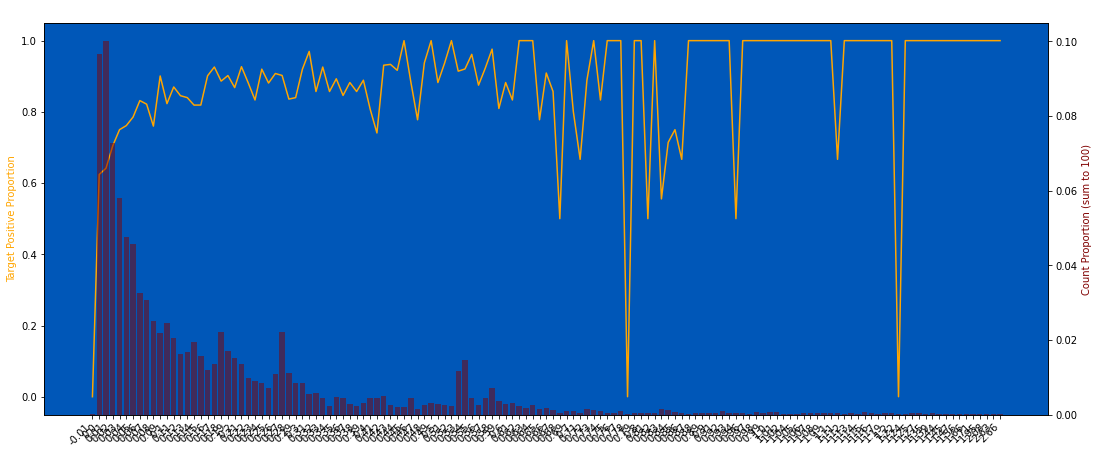

In [149]:
plot_target_check(train, "D_88", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

### High Spike Column

In [384]:
train["S_23_"] = train["S_23"].values

In [385]:
train.loc[(train["S_23"].between(0.13, 0.14)) & (train["S_25"].between(0.97, 0.98)), "S_23_"] = np.nan

In [396]:
train["S_23_"] = train["S_23"].replace((0.13, 0.14), np.nan)
train["S_25_"] = train["S_25"].replace((0.97, 0.98), np.nan)

In [ ]:
%%time
corr_df = train.corr()

In [424]:
train["S_23"].isnull().sum()

445

18593 null count, 0.003 null proportion
0.1317 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


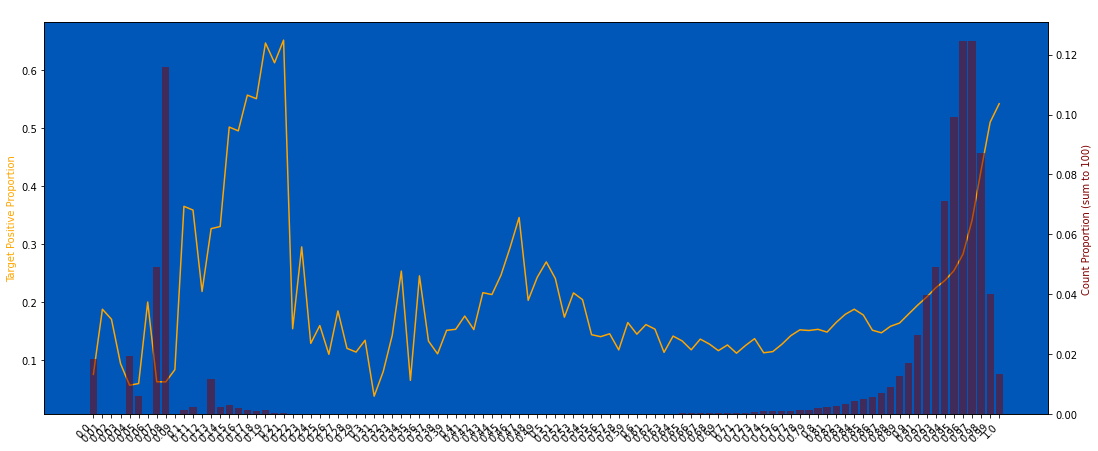

In [423]:
plot_target_check(train, "S_24", q=100, nunique_thr=1000, strfy_x=True)

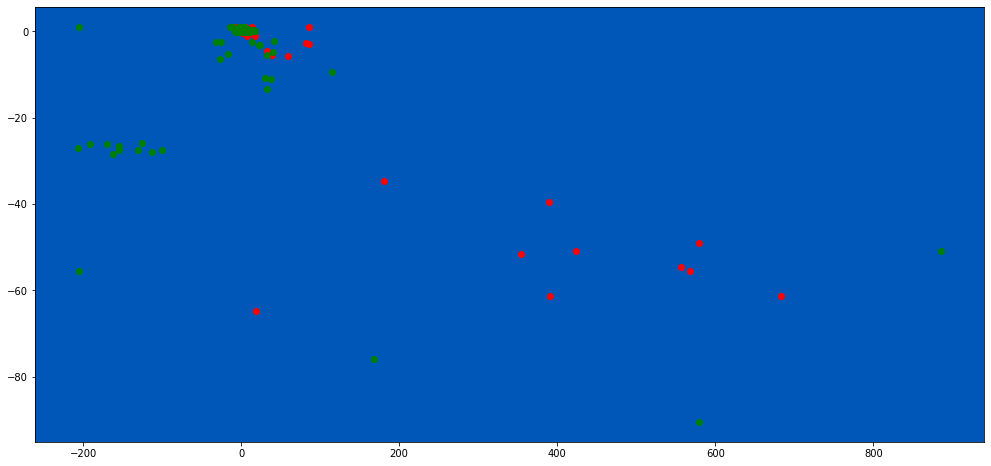

In [428]:
fig, ax = plt.subplots(figsize=(17, 8))
t0 = train.loc[train["target"] == 0]
t1 = train.loc[train["target"] == 1]
plt.scatter(t1["S_23_"], t1["S_24"], color="red")
plt.scatter(t0["S_23_"], t0["S_24"], color="green")
# plt.ylim((-20, 10))
plt.show()

4497692 null count, 0.813 null proportion
0.1929 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


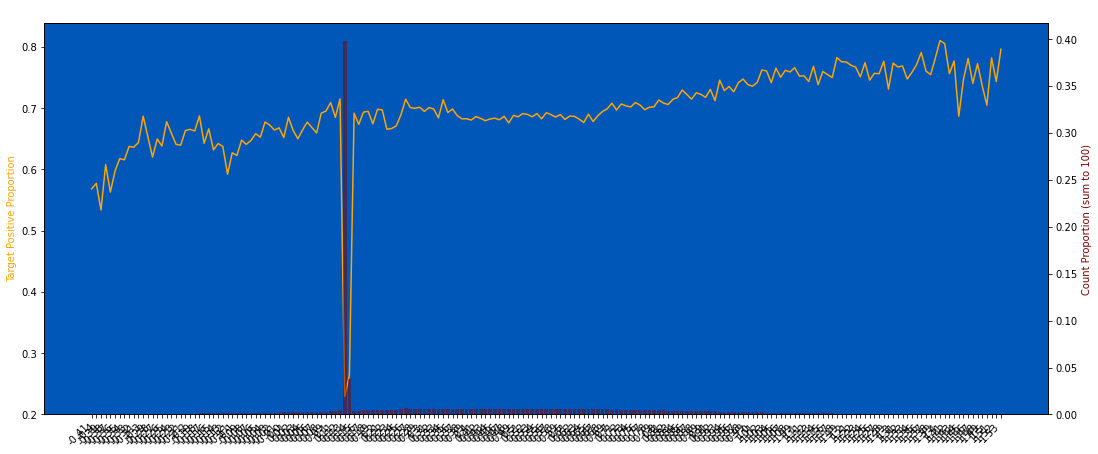

In [386]:
plot_target_check(train, "S_23_", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

In [395]:
corr_df["S_23"]

S_25   -0.1648
D_88   -0.0846
P_2    -0.0724
S_24   -0.0638
B_18   -0.0567
         ...  
D_41    0.0700
D_48    0.0725
S_17    0.0783
D_73    0.0868
S_23    1.0000
Name: S_23, Length: 190, dtype: float64

In [392]:
train.loc[(train["S_23"] == 0.13) | (train["S_23"] == 0.14)]

,customer_ID,row_number,row_number_inv,S_2,target,P_2,S_3,P_3,S_5,S_6,...,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,temp,S_23_
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,13,1,2017-03-09,0,0.9300,0.1200,0.7300,0.0200,0,...,NaN,0.0000,0.0000,0.0000,NaN,0.0000,0.0000,0.0000,NaN,NaN
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,12,2,2017-04-07,0,0.9300,0.1200,0.7200,0.0300,0,...,NaN,0.0000,0.0000,0.0000,NaN,0.0000,0.0000,0.0000,NaN,NaN
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,11,3,2017-05-28,0,0.9500,0.1200,0.7300,0.0400,0,...,NaN,0.0000,0.0000,0.0000,NaN,0.0000,0.0000,0.0000,NaN,NaN
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,10,4,2017-06-13,0,0.9600,0.1100,0.7400,0.0300,0,...,NaN,0.0000,0.0000,0.0000,NaN,0.0000,0.0000,0.0000,NaN,NaN
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,9,5,2017-07-16,0,0.9400,0.1100,0.6900,0.0500,0,...,NaN,0.0000,0.0000,0.0000,NaN,0.0000,0.0000,0.0000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531446,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,5,9,2017-11-05,0,0.9700,0.0900,0.6800,0.0300,0,...,NaN,0.0000,0.0000,0.0000,NaN,0.0000,0.0000,0.0000,NaN,NaN
5531447,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,4,10,2017-12-23,0,0.9800,0.0700,0.7000,0.0000,0,...,NaN,0.0000,0.0000,0.0000,NaN,0.0000,0.0000,0.0000,NaN,NaN
5531448,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,3,11,2018-01-06,0,0.9800,0.1000,0.7100,0.0000,0,...,NaN,0.0000,0.0000,0.0000,NaN,0.0000,0.0000,0.0000,NaN,NaN
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2,12,2018-02-06,0,0.9600,0.1000,0.6400,0.0000,0,...,NaN,0.0000,0.0000,0.0000,NaN,0.0000,0.0000,0.0000,NaN,NaN


In [389]:
train["S_23"]

0.1300      4543597
0.1400       404124
0.2600         6551
0.2700         6297
0.5600         6187
             ...   
-10.3100          1
390.9600          1
19.0600           1
-25.4800          1
10.4000           1
Name: S_23, Length: 1567, dtype: int64

S_23
445 null count, 0.000 null proportion
0.5236 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


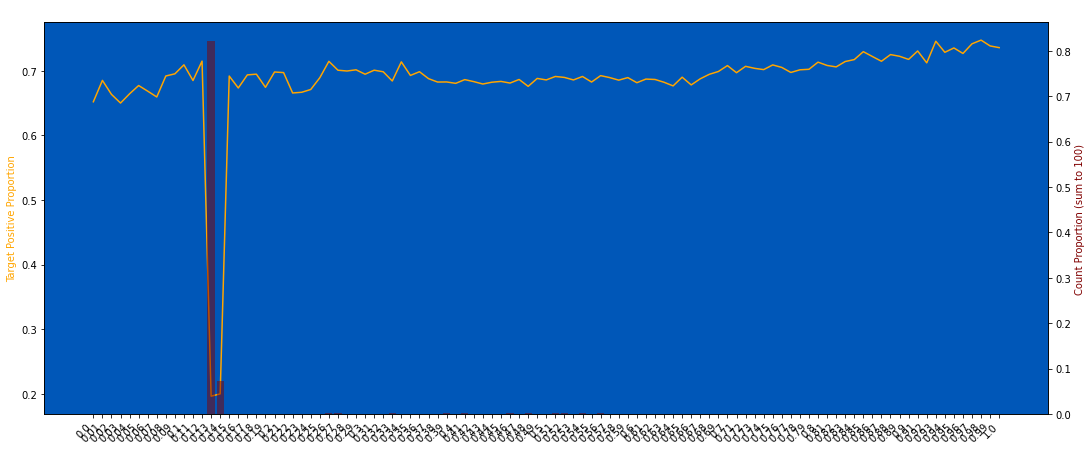

S_25
12847 null count, 0.002 null proportion
0.6575 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


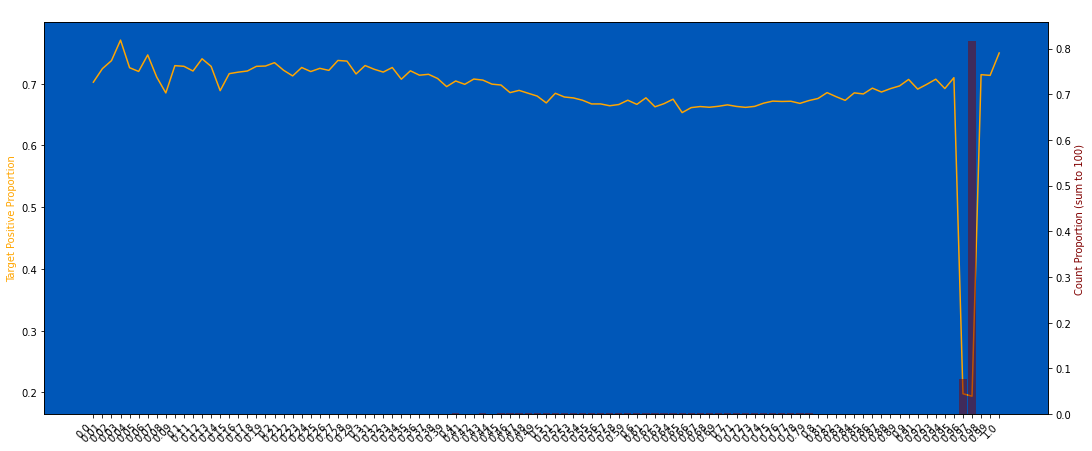

R_9
5218918 null count, 0.943 null proportion
0.2293 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


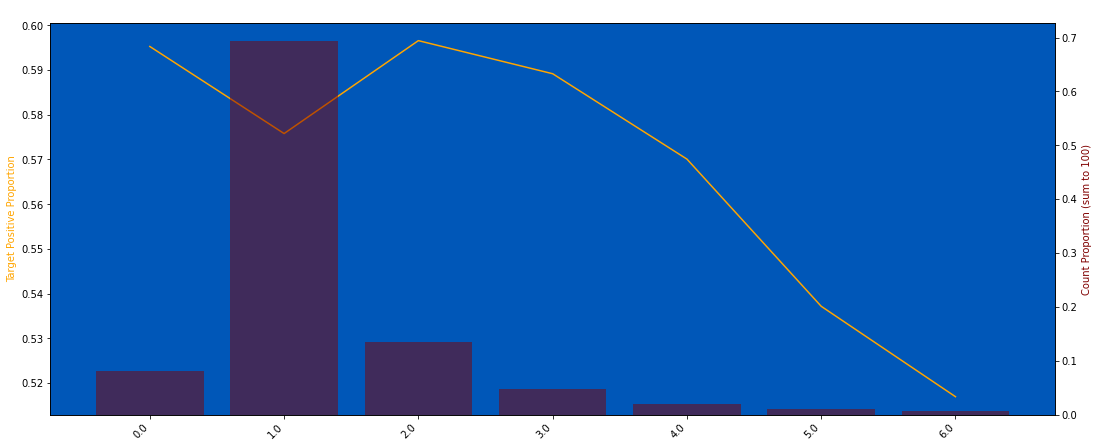

B_15
6923 null count, 0.001 null proportion
0.0858 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


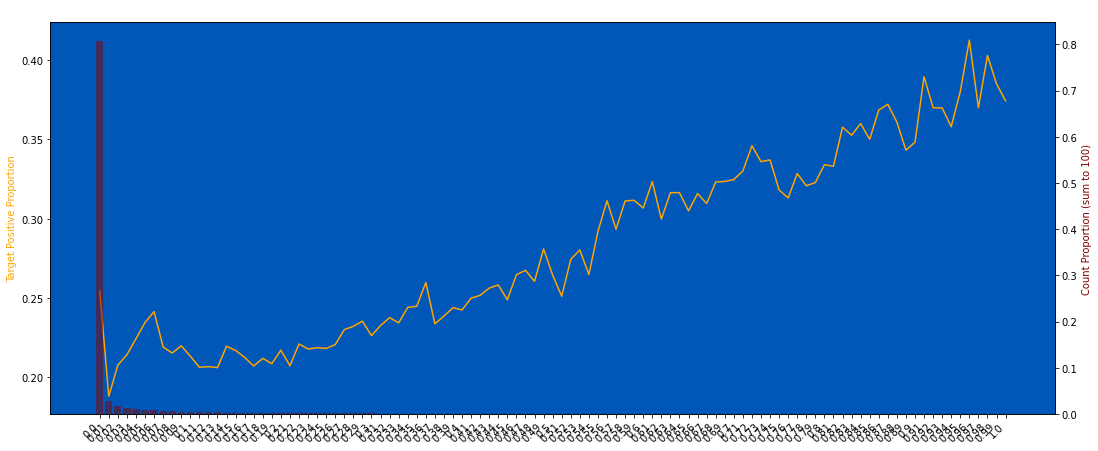

B_25
6923 null count, 0.001 null proportion
0.0858 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


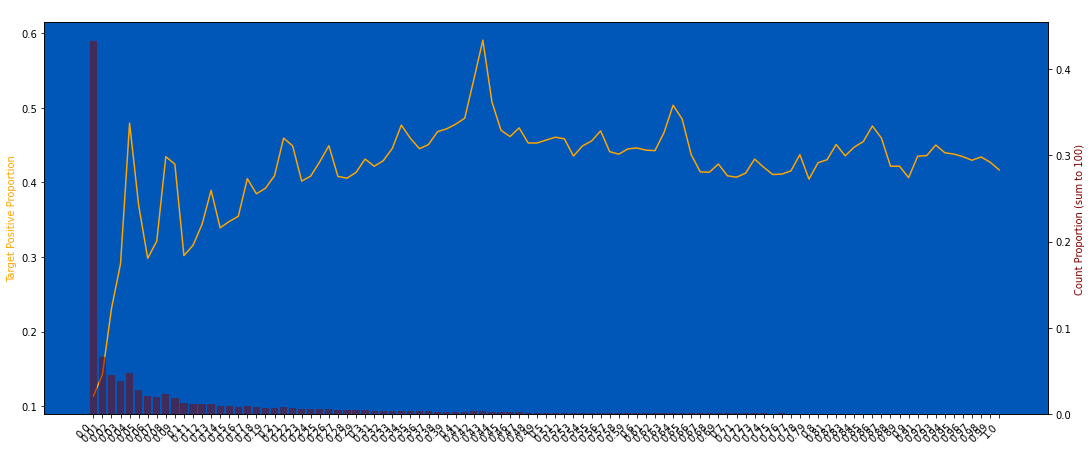

D_63
0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


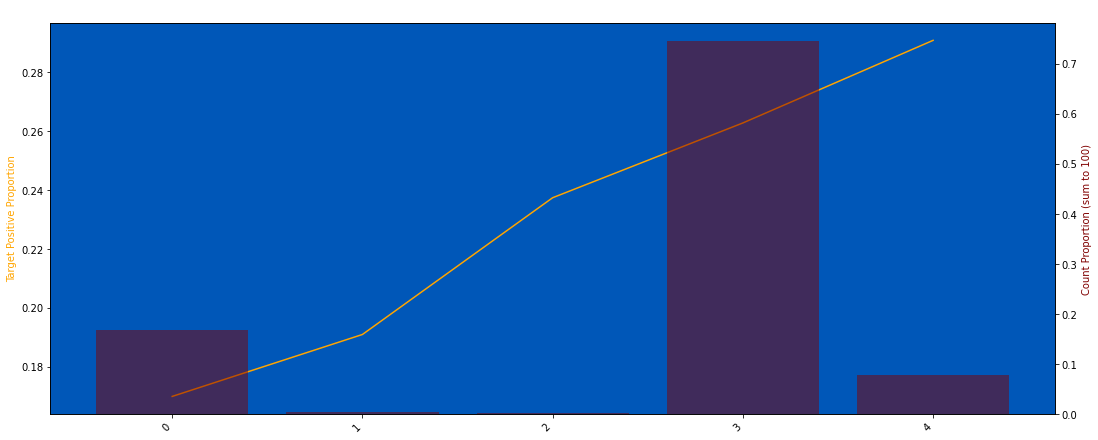

D_64
0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


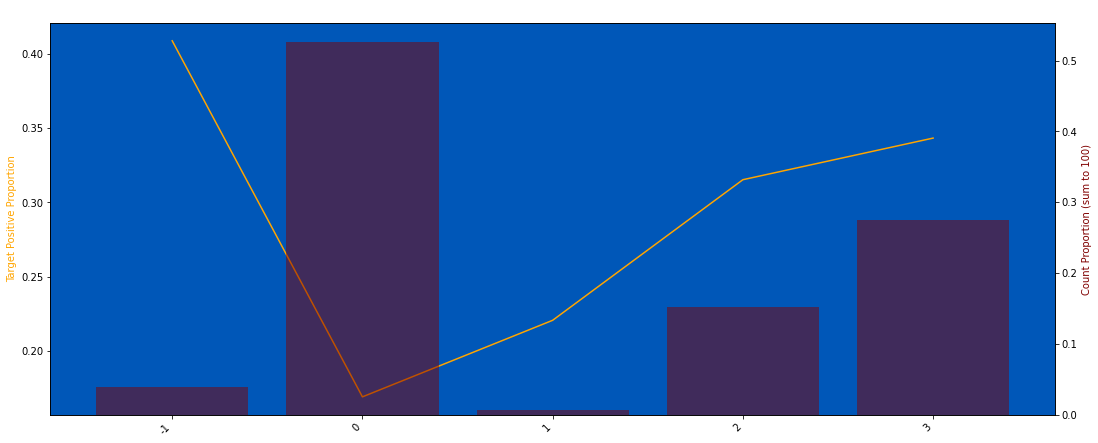

D_68
0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


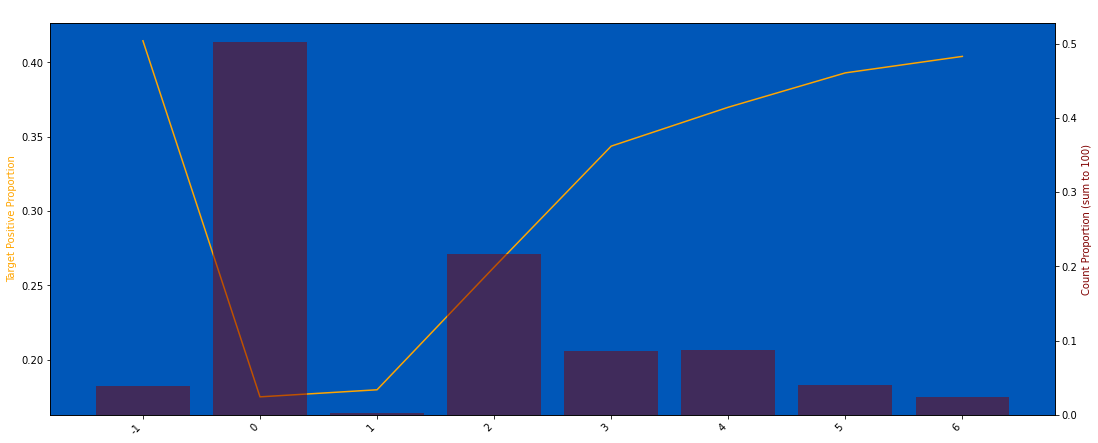

D_82
4058614 null count, 0.734 null proportion
0.2648 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


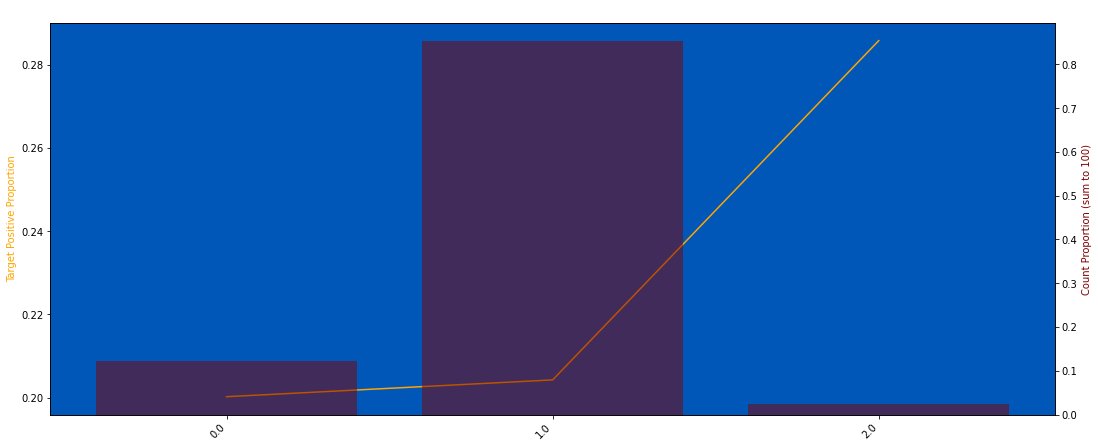

D_126
0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


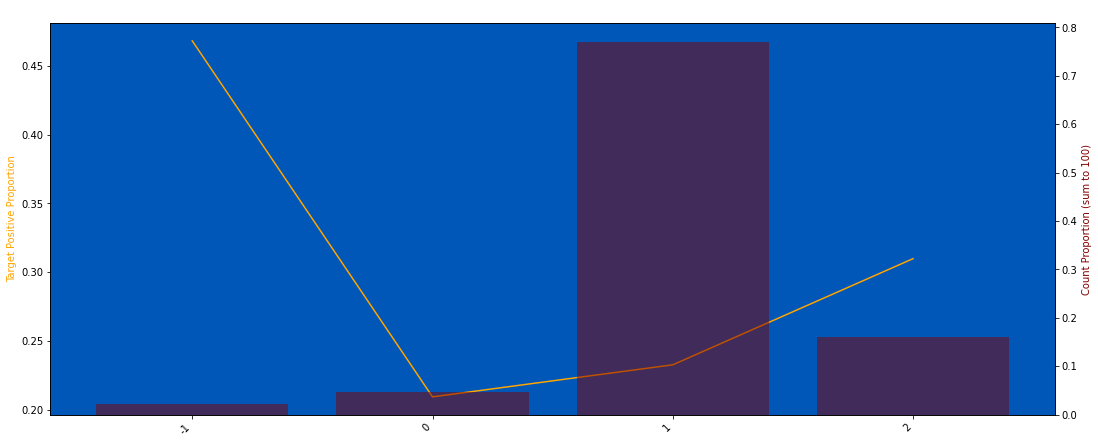

In [378]:
column_with_spike = []
for col in train.columns[5:-1]:
    neighbour_series = train[col].value_counts().sort_index().diff()
    if (neighbour_series.max() > 0.35 * train[col].count()) and (neighbour_series.min() < -0.35 * train[col].count()):
        print(col)
        column_with_spike.append(col)
        plot_target_check(train, col, q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

In [ ]:
high_spike_column = 

In [381]:
train.groupby(["D_63", "D_64"])["customer_ID"].count()

D_63  D_64
0     -1        27023
       0       523050
       1         9820
       2       137990
       3       232250
1     -1         1355
       0        14485
       1          173
       2         3396
       3         6377
2     -1          798
       0         5297
       1           68
       2         1506
       3         2887
3     -1       183160
       0      2135327
       1        23487
       2       622399
       3      1155248
4     -1         4963
       0       231534
       1         3600
       2        73691
       3       124602
5     -1          143
       0         3551
       1           57
       2         1130
       3         2084
Name: customer_ID, dtype: int64

### Missing Feature Group 1

In [306]:
index = 1
m_prop = missing_group_df["missing_proportion"][index]
m_prop

1.8358293330267232

In [307]:
missing_feature_g2 = m.loc[m["missing_proportion"] == m_prop, "column"].tolist()

In [308]:
# sorted(missing_feature_g2)

In [309]:
# plot_heatmap(temp.loc[:, missing_feature_g1].corr(), annot=True, fmt=".2f", figsize=(18, 12))

In [310]:
# missing_cid_list = temp.loc[temp["D_124"].isnull(), "customer_ID"].tolist()

In [29]:
# temp.loc[temp["customer_ID"].isin(missing_cid_list)]

In [138]:
%%time
corr_df = train.corr()

CPU times: user 5min 59s, sys: 26.6 s, total: 6min 26s
Wall time: 6min 39s


In [146]:
corr_df[missing_feature_g2]

,D_129,D_107,D_131,D_128,D_139,D_104,D_141,D_143,D_103,D_130,D_145
row_number,0.0124,-0.0081,-0.0281,0.0151,-0.0037,-0.0081,-0.0037,-0.0037,-0.0080,-0.0242,-0.0053
row_number_inv,0.0094,0.0023,0.0154,0.0151,-0.0080,0.0017,-0.0074,-0.0080,0.0014,0.0146,-0.0052
target,-0.1357,0.1219,0.2329,-0.1887,0.1276,0.1236,0.1246,0.1276,0.1244,0.2111,0.1162
P_2,0.2090,-0.1081,-0.2138,0.2697,-0.1847,-0.1068,-0.1801,-0.1848,-0.1078,-0.2136,-0.1652
S_3,-0.1128,0.0516,0.1146,-0.1666,0.0490,0.0576,0.0468,0.0491,0.0579,0.1113,0.0454
...,...,...,...,...,...,...,...,...,...,...,...
D_141,-0.0008,0.1013,0.1040,-0.0500,0.9982,0.1159,1.0000,0.9977,0.1159,0.1056,0.6323
D_142,0.1133,-0.0027,0.0161,0.1358,NaN,0.0101,0.7779,-0.0098,0.0089,0.0267,0.1390
D_143,-0.0045,0.1018,0.1044,-0.0546,0.9996,0.1162,0.9977,1.0000,0.1163,0.1057,0.6459
D_144,0.0528,0.0512,0.0370,0.0327,0.5693,0.0607,0.5951,0.5682,0.0604,0.0421,0.2146


In [145]:
corr_df[missing_feature_g2].mean(axis=1).sort_values().iloc[-20:]

D_48    0.1366
D_61    0.1380
D_75    0.1402
D_55    0.1479
D_58    0.1527
D_133   0.1596
D_128   0.1713
D_79    0.1988
D_129   0.2016
D_144   0.2077
D_131   0.2236
D_130   0.2414
D_102   0.2456
D_145   0.2863
D_107   0.3313
D_104   0.3469
D_103   0.3472
D_141   0.3746
D_143   0.3753
D_139   0.3754
dtype: float64

In [144]:
sorted(missing_feature_g2)

['D_103',
 'D_104',
 'D_107',
 'D_128',
 'D_129',
 'D_130',
 'D_131',
 'D_139',
 'D_141',
 'D_143',
 'D_145']

In [137]:
for seed in [923, 5197, 6846]:
    X_train, X_val, y_train, y_val = train_test_split(temp_agg, labels["target"], test_size=0.22, random_state=seed)
    cat_features = set(CATEGORY_COLUMNS).intersection(X_train.columns)
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=cat_features)
    lgb_valid = lgb.Dataset(X_val, y_val, categorical_feature=cat_features)
    model = lgb.train(
        params = params,
        train_set = lgb_train,
        num_boost_round = 500,
        valid_sets = [lgb_train, lgb_valid],
        early_stopping_rounds = 300,
        verbose_eval = 1000,
        feval = lgb_amex_metric
    )
    y_val_pred = model.predict(X_val, raw_score=True)
    val_score, val_g, val_t4 = amex_metric(y_val.values, y_val_pred)
    print(seed, val_score)

[LightGBM] [Info] Number of positive: 92814, number of negative: 265138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.057969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83453
[LightGBM] [Info] Number of data points in the train set: 357952, number of used features: 506
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.259292 -> initscore=-1.049653
[LightGBM] [Info] Start training from score -1.049653
923 0.752548208647734
[LightGBM] [Info] Number of positive: 92785, number of negative: 265167
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.117827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83523
[LightGBM] [Info] Number of data points in the train set: 357952, number of used features: 506
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.259211 -> initscore=-1.050075
[LightGBM] [Info] Start traini

In [136]:
y_val_pred = model.predict(X_val, raw_score=True)
val_score, val_g, val_t4 = amex_metric(y_val.values, y_val_pred)
val_score, val_g, val_t4

(0.7582265761262619, 0.9055982526832133, 0.6108548995693105)

In [109]:
# plot_scatterplot(train, "D_118", "D_119")
# plt.show()

In [273]:
for b in tqdm(binary_features):
    mean_series = train_subset.groupby(b)["target"].mean()
    if mean_series[0] > mean_series[1]:
        train_subset[b] = train_subset[b].replace((0, 1), (1, 0))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:10<00:00,  4.36it/s]


In [276]:
# for b in binary_features:
#     mean_series = train_subset.groupby(b)["target"].mean()
#     print(b, mean_series)

In [342]:
n_df = train.groupby("customer_ID").nunique().reset_index()

In [352]:
for col in n_df.columns[5:-1]:
    single_value_proportion = n_df[col].value_counts(normalize=True)[1]
    if single_value_proportion > 0.8:
        print(col, single_value_proportion)

S_16 0.9452554187830808
S_18 0.958316717983583
S_19 0.9871675023370443
S_20 0.9689047815163223
R_2 0.8530266085292855
R_4 0.8881160481398435
R_5 0.8830214005704785
R_6 0.8668854445178062
R_7 0.8855709034174234
R_8 0.8908180853451526
R_12 0.9516030271532948
R_13 0.9467197486233774
R_14 0.9422766406704539
R_15 0.892262803625088
R_17 0.9945697768422337
R_18 0.9996012316059907
R_19 0.9800594012372715
R_20 0.9413548973334815
R_21 0.9589399297906139
R_22 0.9801182359183549
R_23 0.9990738985385029
R_24 0.9436102267750096
R_25 0.9765816178665673
R_27 0.8372414815008509
R_28 0.998224064256188
B_8 0.921974317572176
B_21 0.946767687993149
B_24 0.9398927465554473
B_27 0.9949946939833912
B_31 0.9761109404179006
B_32 0.9421698666195989
B_36 0.9927306482928137
B_41 0.963147699019204
D_54 0.9489532874422821
D_63 0.9349135892859867
D_65 0.8008663951555087
D_69 0.947554329469856
D_72 0.9153739379795299
D_79 0.9137788644034927
D_81 0.942309326604389
D_83 0.9639452358072227
D_84 0.8719539433400231
D_86 0.

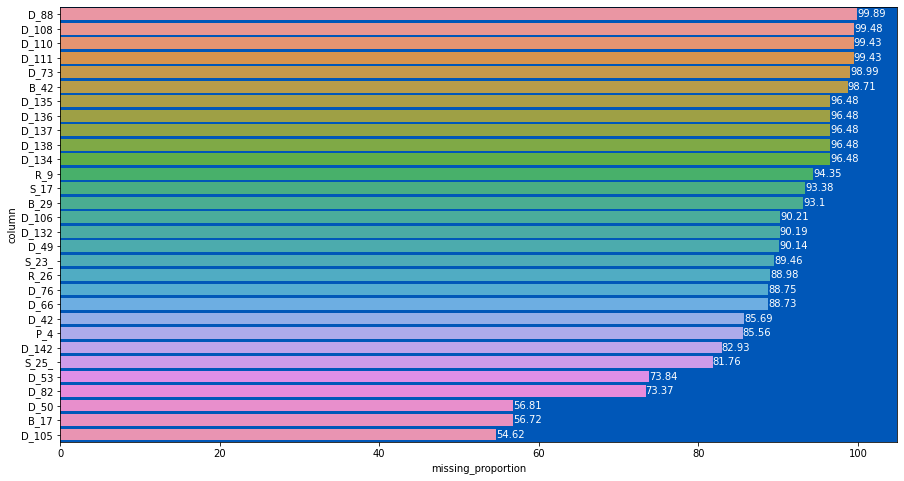

In [459]:
m = plot_missing_proportion_barchart(train)

In [467]:
m = m.reset_index(drop=True)

In [468]:
m.loc[m["column"] == "S_23_"]

,column,missing_proportion
17,S_23_,89.4551


In [470]:
m.loc[10: 25, :]

,column,missing_proportion
10,D_134,96.4801
11,R_9,94.3499
12,S_17,93.3828
13,B_29,93.1046
14,D_106,90.2133
15,D_132,90.1911
16,D_49,90.1376
17,S_23_,89.4551
18,R_26,88.9847
19,D_76,88.7462


In [ ]:
# s23_indices = train_subset[(~train_subset["S_23"].isnull()) & (train_subset["S_25"].isnull())].index

### S_23 & S_25 analysis

In [41]:
train["S_23_"] = train["S_23"].replace((0.13, 0.14), np.nan)
train["S_25_"] = train["S_25"].replace((0.96, 0.97), np.nan)

In [72]:
train.loc[train["S_23_"] == 0.12].shape[0], train.loc[train["S_23_"] == 0.15].shape[0]

(5055, 3799)

In [73]:
train.loc[train["S_25_"] == 0.95].shape[0], train.loc[train["S_25_"] == 0.98].shape[0]

(4062, 3928)

In [83]:
for col in tqdm(train.columns[5:-3]):
    s = train[
        (train["S_23_"].isnull()) & 
        (~train[col].isnull())
    ].shape[0]
    if abs(s - 4427) < 600:
        print(col, s)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [10:51<00:00,  3.48s/it]


In [84]:
%%time
new_corr_df = train.corr()

CPU times: user 5min 46s, sys: 17.7 s, total: 6min 4s
Wall time: 6min 11s


In [ ]:
for col in tqdm(train.columns[5:-3]):
    s = train[
        (train["S_23_"].isnull()) & 
        (~train[col].isnull())
    ].shape[0]

In [99]:
train.loc[train["S_23_"].between(0.12, 0.15), "S_24"].describe()

count   8,854.0000
mean        0.9571
std         0.0462
min         0.0400
25%         0.9500
50%         0.9600
75%         0.9800
max         1.0500
Name: S_24, dtype: float64

In [100]:
train.loc[train["S_23_"].between(0, 1), "S_24"].describe()

count   474,877.0000
mean          0.9627
std           0.0384
min          -0.2100
25%           0.9500
50%           0.9700
75%           0.9800
max           1.0500
Name: S_24, dtype: float64

In [98]:
new_corr_df["S_25_"].sort_values().iloc[-10:]

B_25    0.1905
D_60    0.2226
S_13    0.2487
S_22    0.3569
S_24    0.4298
S_23_   0.4616
S_23    0.4733
S_25    1.0000
temp    1.0000
S_25_   1.0000
Name: S_25_, dtype: float64

In [87]:
new_corr_df["S_23_"]

row_number       -0.0037
row_number_inv    0.0041
target            0.0113
P_2              -0.0182
S_3               0.0118
                   ...  
D_144            -0.0004
D_145             0.0002
temp              0.4616
S_23_             1.0000
S_25_             0.4616
Name: S_23_, Length: 193, dtype: float64

4948166 null count, 0.895 null proportion
0.1965 of the targets have label = 1
Top & Bottom 7% are dropped from this chart


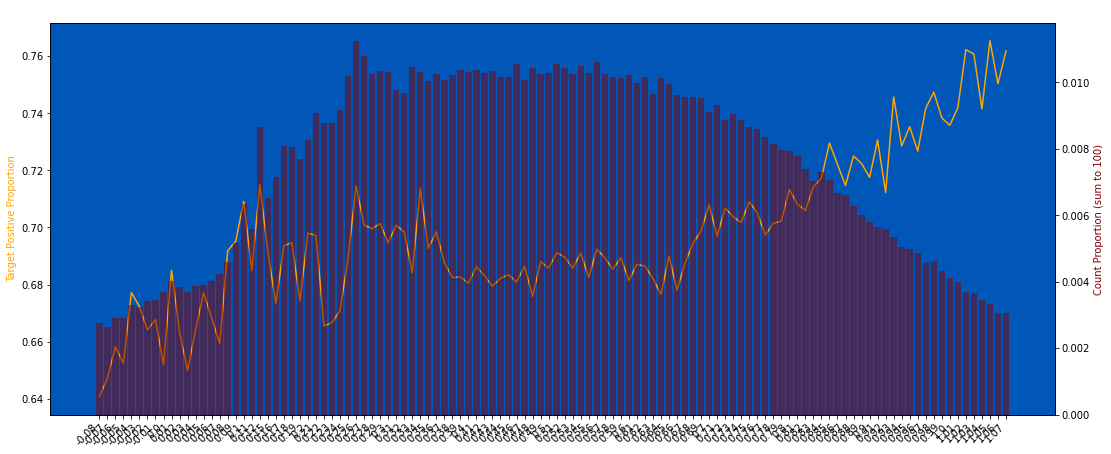

In [46]:
plot_target_check(train, "S_23_", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, percentile_drop=7)

4940670 null count, 0.893 null proportion
0.1954 of the targets have label = 1
Top & Bottom 8% are dropped from this chart


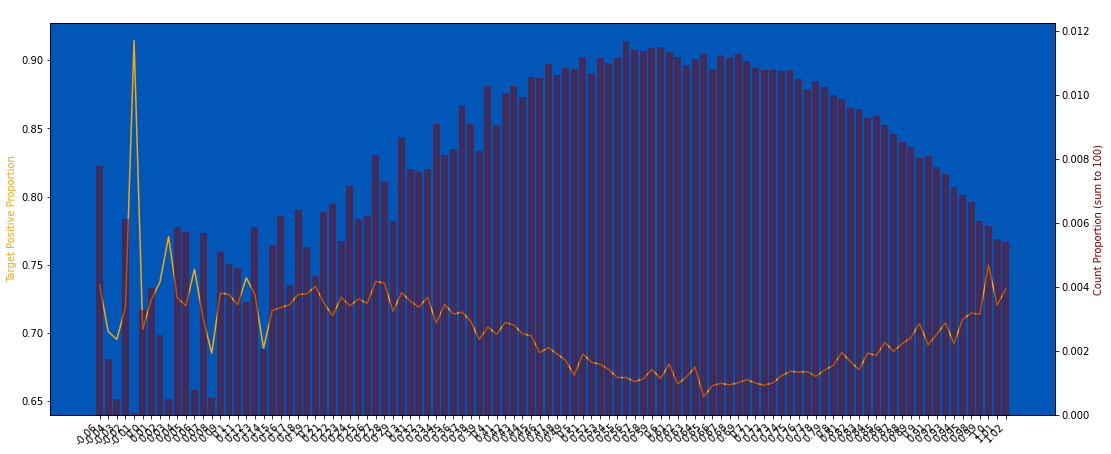

In [47]:
plot_target_check(train, "S_25_", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, percentile_drop=8)

In [19]:
train_subset = train.loc[:, ["customer_ID", "S_2", "row_number", "target"] + ["S_23", "S_25"] + strong_columns]

In [20]:
train_subset["S_23"] = train_subset["S_23"].replace((0.13, 0.14), np.nan)
train_subset["S_25"] = train_subset["S_25"].replace((0.96, 0.97), np.nan)

32721

5055

In [23]:
train_subset.loc[train_subset["S_23"] == 0.15].shape[1]

17

In [473]:
s25_indices = train_subset[(~train_subset["S_23"].isnull()) & (train_subset["S_25"].isnull())].index

In [474]:
train_subset.loc[s23_indices, "S_23"] = 0.135
train_subset.loc[s25_indices, "S_25"] = 0.965

4915445 null count, 0.889 null proportion
0.1929 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


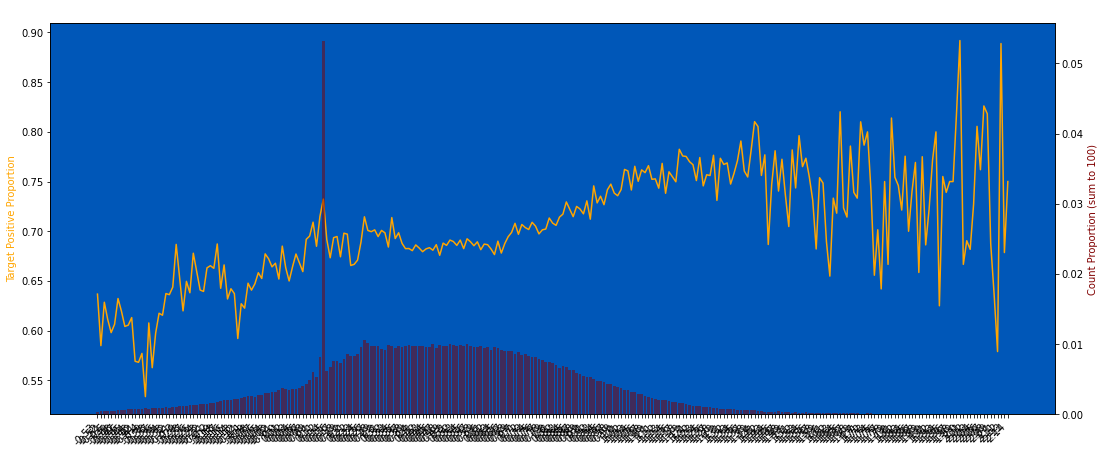

In [475]:
plot_target_check(train_subset, "S_23", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

4915445 null count, 0.889 null proportion
0.1929 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


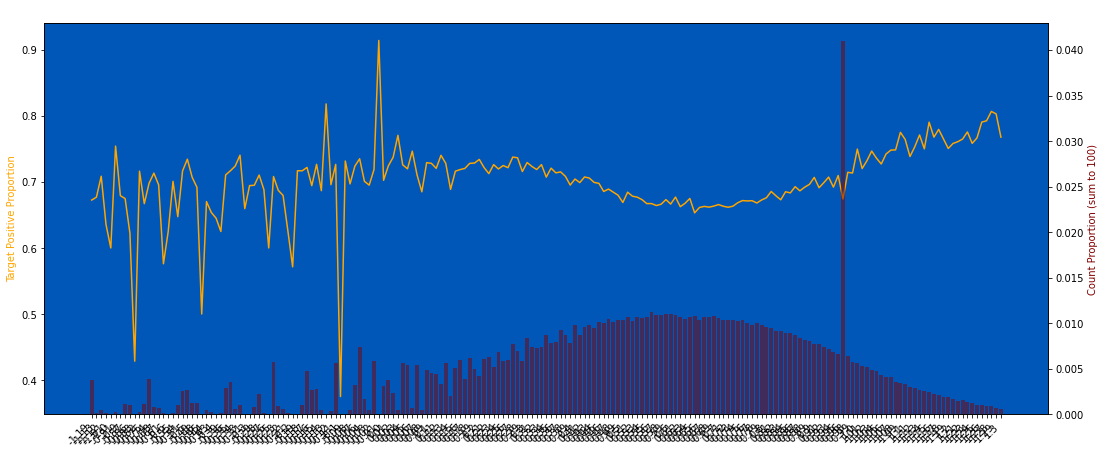

In [476]:
plot_target_check(train_subset, "S_25", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

In [441]:
test_strategy(train_subset)

Done insertion
Average done
Minimum done
Maximum done
Standard Deviation done
Last entry done
First entry done
Second last entry done
Third last entry done
MA2 for Recency 1 done
MA2 for Recency 2 done
MA2 for Recency 3 done
MA2 for least Recency done
MA3 for Recency 1 done
MA3 for Recency 2 done


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:57<00:00,  4.12s/it]


[LightGBM] [Info] Number of positive: 95012, number of negative: 272118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.701389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77055
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 322
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258797 -> initscore=-1.052233
[LightGBM] [Info] Start training from score -1.052233
[300]	training's binary_logloss: 0.287422	training's amex: 0.756218	valid_1's binary_logloss: 0.287885	valid_1's amex: 0.754059
[600]	training's binary_logloss: 0.24823	training's amex: 0.767732	valid_1's binary_logloss: 0.250569	valid_1's amex: 0.7612
[900]	training's binary_logloss: 0.239628	training's amex: 0.774269	valid_1's binary_logloss: 0.243923	valid_1's amex: 0.764884
1020 0.7661124460592441
[LightGBM] [Info] Number of positive: 95160, number of negative: 271970
[LightGBM] [Warning] A

In [361]:
train_subset_agg_.describe()

,S_16_last,S_16_second_last,S_16_first,S_16_avg,S_16_min,S_16_max,S_16_std,S_16_ma2_r1,S_16_ma3_r1,S_16_ma3_r2,...,S_16_general_trend,S_16_sprint,S_16_previous_sprint,S_16_acceleration,S_16_range,S_16_displacement,S_16_last_first_ratio,S_16_velocity,S_16_last_minus_avg,S_16_coef_var
count,"458,913.0000","453,793.0000","458,913.0000","458,913.0000","458,913.0000","458,913.0000","453,793.0000","458,913.0000","458,913.0000","441,917.0000",...,"458,913.0000","453,793.0000","447,695.0000","7,977.0000","458,913.0000","458,913.0000","15,930.0000","458,913.0000","458,913.0000","25,212.0000"
mean,0.0542,0.0535,0.0378,0.0495,0.0043,0.1376,0.0529,0.0537,0.0533,0.0497,...,0.1622,0.0010,0.0010,0.0052,0.1332,0.0165,inf,0.0025,0.0047,1.8098
std,0.9262,0.8771,0.7032,0.5949,0.1577,1.4631,0.5476,0.8716,0.8337,0.7107,...,8.6925,0.4603,0.4326,88.0610,1.4238,0.9951,NaN,0.1075,0.6559,1.0076
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,"-1,161.0769",-58.7600,-61.0200,"-5,876.9863",0.0000,-150.9400,0.0000,-19.5833,-69.7700,0.0000
25%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,-0.1667,0.0000,0.0000,0.0000,0.0000,0.0000,1.0508
50%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.0730,0.0000,0.0000,1.5533
75%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,0.0000,0.0000,2.4410
max,146.3900,157.3000,231.7500,96.3685,45.6100,231.7500,84.5509,151.8450,156.6067,103.6567,...,"1,985.5716",72.1500,100.4200,"1,131.0820",229.0300,135.5000,inf,19.3571,96.7746,3.6056


In [317]:
n_df_desc = n_df.describe().T

In [338]:
n_df_desc


,count,mean,std,min,25%,50%,75%,max
row_number,"458,913.0000",12.0534,2.6103,1.0000,13.0000,13.0000,13.0000,13.0000
row_number_inv,"458,913.0000",12.0534,2.6103,1.0000,13.0000,13.0000,13.0000,13.0000
S_2,"458,913.0000",12.0534,2.6103,1.0000,13.0000,13.0000,13.0000,13.0000
target,"458,913.0000",1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
P_2,"458,913.0000",6.6958,2.4632,0.0000,5.0000,7.0000,8.0000,13.0000
...,...,...,...,...,...,...,...,...
D_142,"458,913.0000",0.9555,2.1005,0.0000,0.0000,0.0000,0.0000,10.0000
D_143,"458,913.0000",1.0151,0.1611,0.0000,1.0000,1.0000,1.0000,2.0000
D_144,"458,913.0000",1.3445,1.2210,1.0000,1.0000,1.0000,1.0000,13.0000
D_145,"458,913.0000",1.0623,0.3265,0.0000,1.0000,1.0000,1.0000,8.0000


In [325]:
less_nunique_col_list = n_df_desc.loc[n_df_desc["max"] <= 2].index.tolist()
less_nunique_col_list.remove("target")
less_nunique_col_list.remove("temp")

In [331]:
train.loc[:, "D_111"].value_counts()

2.0000    24688
1.0000     5117
0.0000     1529
Name: D_111, dtype: int64

In [336]:
train.groupby("customer_ID")["D_111"].mean().describe()

count   4,087.0000
mean        1.7278
std         0.5497
min         0.0000
25%         2.0000
50%         2.0000
75%         2.0000
max         2.0000
Name: D_111, dtype: float64

In [327]:
train.loc[:, less_nunique_col_list]

,S_6,S_18,S_20,R_2,R_4,R_13,R_14,R_15,R_17,R_18,...,D_120,D_127,D_128,D_129,D_130,D_135,D_137,D_139,D_140,D_143
0,0,0,0,0,0,0,0,0,0,0,...,0.0000,1,1.0000,1.0000,0.0000,NaN,NaN,0.0000,0.0000,0.0000
1,0,0,0,0,0,0,0,0,0,0,...,0.0000,1,1.0000,1.0000,0.0000,NaN,NaN,0.0000,0.0000,0.0000
2,0,0,0,0,0,0,0,0,0,0,...,0.0000,1,1.0000,1.0000,0.0000,NaN,NaN,0.0000,0.0000,0.0000
3,0,0,0,0,0,0,0,0,0,0,...,0.0000,1,1.0000,1.0000,0.0000,NaN,NaN,0.0000,0.0000,0.0000
4,0,0,0,0,0,0,0,0,0,0,...,0.0000,1,1.0000,1.0000,0.0000,NaN,NaN,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531446,0,0,0,0,0,0,0,0,0,0,...,0.0000,1,1.0000,1.0000,0.0000,NaN,NaN,0.0000,0.0000,0.0000
5531447,0,0,0,0,0,0,0,0,0,0,...,0.0000,1,1.0000,1.0000,0.0000,NaN,NaN,0.0000,0.0000,0.0000
5531448,0,0,0,0,0,0,0,0,0,0,...,0.0000,1,1.0000,1.0000,0.0000,NaN,NaN,0.0000,0.0000,0.0000
5531449,0,0,0,0,0,0,0,0,0,0,...,0.0000,1,1.0000,1.0000,0.0000,NaN,NaN,0.0000,0.0000,0.0000


In [248]:
n = train.nunique()

In [253]:
binary_features = n[n == 2].index.tolist()[1:]

In [300]:
train_subset = train.loc[:, ["customer_ID", "S_2", "row_number", "target"] + binary_features]

In [301]:
train_subset.shape

(5531451, 49)

In [302]:
train_subset["D_66"] = train_subset["D_66"].fillna(0.5)
train_subset["D_135"] = train_subset["D_135"].fillna(-1)
train_subset["D_137"] = train_subset["D_137"].fillna(-1)

In [303]:
for b_col in binary_features:
    if  train[b_col].isnull().sum() > 0:
        print(b_col, train[b_col].isnull().sum())

B_8 22268
B_33 2016
D_54 2016
D_66 4908097
D_103 101548
D_109 1597
D_114 176716
D_116 176716
D_120 176716
D_128 101548
D_129 101548
D_130 101548
D_135 5336752
D_137 5336752
D_139 101548
D_140 40632
D_143 101548


5500117 null count, 0.994 null proportion
0.2473 of the targets have label = 1


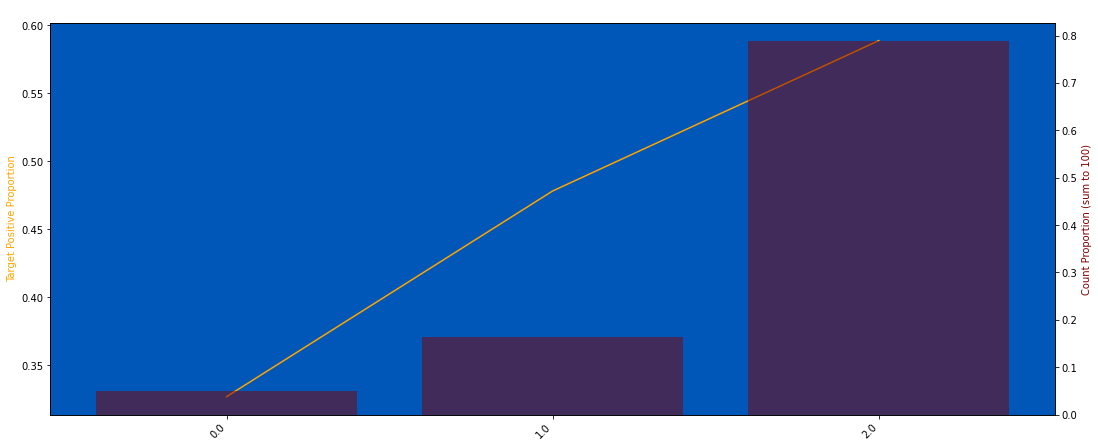

In [337]:
plot_target_check(train, "D_111", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)
# plot_target_check(train, "D_137", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [287]:
for a in ["S_", "R_", "B_", "D_"]:
    temp_features = [c for c in binary_features if c.startswith(a)]
    train_subset[a] = train_subset.loc[:, temp_features].sum(axis=1)

In [304]:
train_subset.shape

(5531451, 49)

In [305]:
test_strategy(train_subset)

Done insertion
Average done
Minimum done
Maximum done
Standard Deviation done
Last entry done
First entry done
Second last entry done
Third last entry done
MA2 for Recency 1 done
MA2 for Recency 2 done
MA2 for Recency 3 done
MA2 for least Recency done
MA3 for Recency 1 done
MA3 for Recency 2 done


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [13:13<00:00, 18.90s/it]


[LightGBM] [Info] Number of positive: 95012, number of negative: 272118
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.562162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14265
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 956
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258797 -> initscore=-1.052233
[LightGBM] [Info] Start training from score -1.052233
[300]	training's binary_logloss: 0.340479	training's amex: 0.665523	valid_1's binary_logloss: 0.338256	valid_1's amex: 0.670639
[600]	training's binary_logloss: 0.308198	training's amex: 0.675191	valid_1's binary_logloss: 0.306466	valid_1's amex: 0.678415
[900]	training's binary_logloss: 0.301893	training's amex: 0.680326	valid_1's binary_logloss: 0.301123	valid_1's amex: 0.681437
1020 0.6830942700322087
[LightGBM] [Info] Number of

In [246]:
corr_df["target"].sort_values()

P_2      -0.6107
B_18     -0.4875
B_2      -0.4831
B_33     -0.4530
D_62     -0.3522
           ...  
B_38      0.4649
D_44      0.4705
B_9       0.4759
D_48      0.5493
target    1.0000
Name: target, Length: 190, dtype: float64